<a href="https://colab.research.google.com/github/aishvellappally/Speech-Encoder/blob/master/Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from ast import literal_eval

In [3]:
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
import spacy 
from tensorflow.keras import initializers
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.layers
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, Flatten, Activation, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
import tensorflow.keras.callbacks
import os

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
    print('multi-gpu')
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()
    print('cpu')

print("REPLICAS: ", strategy.num_replicas_in_sync)

cpu
REPLICAS:  1


In [0]:
np.random.seed(42)

In [0]:
data = pd.read_excel('data.xlsx', delimiter = '\t')

In [0]:
data.head()

,path,actor,gender,emotion,valence,activation
0,speech_files/Ses01F_impro01/Ses01F_impro01_F00...,F01,F,neu,low,low
1,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,neu,high,mid
2,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,exc,high,mid
3,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,exc,high,high
4,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,neu,high,low


In [0]:
data = data.drop(['MFB', 'normalized'], axis=1)

In [0]:
data=data.drop(['Unnamed: 0'],axis=1)

In [0]:
data.replace(['low','mid','high'], [0,1,2], inplace = True)


In [0]:
for i in range(20):
  if (i == 0):
    feat1_df = pd.read_pickle('drive/My Drive/feature_files/feat%s.pkl'%(i+1))
    result = feat1_df
  else:
    feat_df = pd.read_pickle('drive/My Drive/feature_files/feat%s.pkl'%(i+1))
    frames = [result,feat_df]
    result = pd.concat(frames)

In [0]:
result.describe

<bound method NDFrame.describe of 0        [[0.050485510982018166, -0.4740589625502711, -...
1        [[0.4079305590203414, 1.094093912771009, 0.882...
2        [[-0.7429864165689963, 1.1230922602270565, 1.8...
3        [[0.535196903460652, -0.03808107946509253, -0....
4        [[-1.1152232044198171, -0.06361567822243096, -...
                               ...                        
10034    [[0.5374178145754992, 0.6722891938399382, 0.21...
10035    [[0.5880829466230881, 0.42633139691203165, 0.0...
10036    [[-0.9971212568554284, -0.08129033576683752, 0...
10037    [[-0.026595874521982137, -0.4252976670942085, ...
10038    [[0.5370853148216128, 0.7652084455059001, 0.38...
Name: normalized, Length: 10039, dtype: object>

In [0]:
data['features']=result

In [0]:
data.head()

,path,actor,gender,emotion,valence,activation,features
0,speech_files/Ses01F_impro01/Ses01F_impro01_F00...,F01,F,neu,0,0,"[[0.050485510982018166, -0.4740589625502711, -..."
1,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,neu,2,1,"[[0.4079305590203414, 1.094093912771009, 0.882..."
2,speech_files/Ses01M_impro03/Ses01M_impro03_F02...,F01,F,exc,2,1,"[[-0.7429864165689963, 1.1230922602270565, 1.8..."
3,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,exc,2,2,"[[0.535196903460652, -0.03808107946509253, -0...."
4,speech_files/Ses01M_impro03/Ses01M_impro03_F01...,F01,F,neu,2,0,"[[-1.1152232044198171, -0.06361567822243096, -..."


In [0]:
# train _ val _ test split
actor_group = data.groupby('actor')

In [0]:
num_actors = actor_group.size()

In [0]:
num_actors

actor
F01     873
F02     859
F03    1048
F04     987
F05    1033
M01     946
M02     952
M03    1088
M04    1116
M05    1137
dtype: int64

In [0]:
#training for emotion classifier
df_train = data[0:3767]
df_train= df_train.append(data[4800:8902]) #training data has F01-F04, M01-M04

In [0]:
df_train = df_train.reset_index(drop = True)

In [0]:
df_train_shuff = shuffle(df_train, random_state=42)

In [0]:
df_train_shuff

,path,actor,gender,emotion,valence,activation,features
7794,speech_files/Ses04M_script02_1/Ses04M_script02...,M04,M,exc,1,0,"[[-0.10906241270490516, -0.043124719471154954,..."
503,speech_files/Ses01M_script01_1/Ses01M_script01...,F01,F,ang,0,2,"[[-0.03509190950606585, 0.6225776587168179, 0...."
6496,speech_files/Ses03M_impro05a/Ses03M_impro05a_M...,M03,M,xxx,0,2,"[[0.2735971425279483, 0.2641175535829344, -0.1..."
5046,speech_files/Ses02M_impro03/Ses02M_impro03_M01...,M02,M,hap,2,2,"[[0.041337888254272884, 0.10609194808524976, -..."
2298,speech_files/Ses03F_impro08/Ses03F_impro08_F02...,F03,F,neu,1,1,"[[0.4262206875174722, -0.443585043402195, -0.3..."
...,...,...,...,...,...,...,...
5226,speech_files/Ses02M_script03_2/Ses02M_script03...,M02,M,fru,0,1,"[[0.08388802173717781, 0.08193687326233184, -0..."
5390,speech_files/Ses02M_script03_2/Ses02M_script03...,M02,M,fru,0,0,"[[-0.08692197806540758, -0.20013992630093408, ..."
860,speech_files/Ses01F_script02_1/Ses01F_script02...,F01,F,hap,2,0,"[[-0.9491783861000763, -0.3252826994574215, -0..."
7603,speech_files/Ses04M_script02_1/Ses04M_script02...,M04,M,xxx,0,0,"[[0.3408864634550491, 0.13185305285829071, -0...."


In [0]:
np.unique(df_train_shuff['actor'])

array(['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04'],
      dtype=object)

In [0]:
X_train = df_train_shuff['features']
y1_train = df_train_shuff['valence']

In [0]:
y1_train

7794    1
503     0
6496    0
5046    2
2298    1
       ..
5226    0
5390    0
860     2
7603    0
7270    0
Name: valence, Length: 7869, dtype: int64

In [0]:
df_test = data[['features','valence']][8902:10039] #test set has M05
df_test = df_test.reset_index(drop=True)
df_test = shuffle(df_test)
X_test= df_test['features']
y1_test=df_test['valence']

X_test

556    [[-0.15926841459002272, -0.4076696312896961, -...
241    [[-0.6549255057733625, 0.29846889100269525, 0....
513    [[0.18957583541396703, -0.25070983329062524, -...
204    [[0.5354949737204711, 0.7044430544139382, 0.30...
148    [[0.4942554133264459, -0.02960022729107716, 0....
                             ...                        
731    [[-0.05488042403474618, -0.47809356508522177, ...
186    [[0.58321706485984, 0.5411173247107891, 0.1431...
807    [[-0.6215119754287598, -0.9053124659436508, -0...
462    [[-0.080803740619455, -0.3916059364828743, -0....
879    [[0.5736778583391235, 0.5382319217991249, 0.35...
Name: features, Length: 1137, dtype: object

In [0]:
y1_test

556    2
241    1
513    0
204    2
148    1
      ..
731    2
186    2
807    0
462    0
879    0
Name: valence, Length: 1137, dtype: int64

In [0]:
df_val = data[['features','valence']][3767:4800] #validation set has F05
df_val = df_val.reset_index(drop=True)
df_val=shuffle(df_val)
X_val = df_val['features']
y1_val = df_val['valence']
y1_val

305    0
164    2
422    0
190    0
123    2
      ..
270    0
251    0
640    2
208    0
343    2
Name: valence, Length: 1033, dtype: int64

In [0]:
np.unique(data['actor'][3767:4800])

array(['F05'], dtype=object)

In [0]:
class_weights_val = {0: 1,
                1: 3.4,
                2: 1.9}
class_weights_act = {0: 1.2,
                1: 1.3,
                2: 1}               

In [0]:
num_classes = 3
def onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr.astype(int)).reshape(-1)]

y1_train = onehot(y1_train, num_classes)
y1_test = onehot(y1_test, num_classes)
y1_val = onehot(y1_val, num_classes)

In [0]:
y1_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [0]:
y1_val

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [0]:
y1_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [88]:
X_train.shape[0]

7869

In [0]:
X1_train = np.zeros((X_train.shape[0],448,40))
for i in range(X_train.shape[0]):
  for j in range(448):
      X1_train[i][j][0:40]=X_train[i][j][0:40]

In [0]:
X1_val = np.zeros((X_val.shape[0],448,40))
for i in range(X_val.shape[0]):
  for j in range(448):
      X1_val[i][j][0:40]=X_val[i][j][0:40]

In [0]:
X1_test = np.zeros((X_test.shape[0],448,40))
for i in range(X_test.shape[0]):
  for j in range(448):
      X1_test[i][j][0:40]=X_test[i][j][0:40]

In [0]:
def create_model():
  nb_filter = [128,128,128,64,64]
  filter_length = [2,2,2,2,2]
  pool_length = 2
  in_frames = Input(shape=(448,40), dtype='float')
  
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(in_frames)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
  embedded = Conv1D(filters=128,kernel_size=2,padding='same',activation='relu',kernel_initializer='glorot_normal',
                    strides=1)(embedded)
  embedded = MaxPooling1D(pool_size=pool_length)(embedded)
  embedded = Dropout(0.2)(embedded)
    
   
  b_gru_1 = Bidirectional(GRU(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=0))(embedded)
  #b_gru_2 = Bidirectional(GRU(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=0))(b_gru_1)

  output = Dropout(0.2)(b_gru_1)
  output = Dense(3, activation='softmax')(output)

  model = Model(inputs=in_frames, outputs=output)

  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['ACCURACY',UAR])
  return model


In [0]:
from keras import backend as K
def UAR(y_true, y_pred):
  TP = [0,0,0]
  FN = [0,0,0]
  for i in range(y_true.shape[0]):
    if (y_true[i][0]==1):
      if (y_pred[i][0]>=0.5):
        TP[0]+=1
      else:
        FN[0]+=1
    elif (y_true[i][1]==1):
      if (y_pred[i][1]>=0.5):
        TP[1]+=1
      else:
        FN[1]+=1
    else:
      if (y_pred[i][2]>=0.5):
        TP[2]+=1
      else:
        FN[2]+=1
    avg_recall = 1/3* ((TP[0]/(TP[0]+FN[0]))+(TP[1]/(TP[1]+FN[1]))+(TP[2]/(TP[2]+FN[2])))
  return avg_recall

In [102]:
with strategy.scope():
  model = Sequential()
  model.add(Input(shape=(448,40),dtype='float'))
  model.add(Conv1D(128, 2, padding='causal',input_shape=(448,40), activation = 'selu', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
    #model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(128, 2, padding='causal', activation = 'selu', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
    #model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', activation = 'selu', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
    #model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', activation = 'selu', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
  # model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(64, 2, padding='causal', activation = 'selu', use_bias=True, kernel_initializer='lecun_normal',
                   kernel_regularizer = l2(1e-6)))
  model.add(BatchNormalization())
    #model.add(Activation('selu'))
  model.add(MaxPooling1D(2))
  model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2, dropout = 0.2, implementation=2, 
                              use_bias=True,kernel_regularizer=l2(1e-5),recurrent_regularizer = l2(1e-6))))
  model.add(Bidirectional(GRU(64, return_sequences=False, recurrent_dropout=0.2, dropout = 0.2, implementation=2, 
                              use_bias=True,kernel_regularizer=l2(1e-5),recurrent_regularizer = l2(1e-6))))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(3))
  model.add(Activation('softmax'))
  opt = RMSprop(momentum=0.9)
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', UAR])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 448, 128)          10368     
_________________________________________________________________
batch_normalization_41 (Batc (None, 448, 128)          512       
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 224, 128)          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 224, 128)          32896     
_________________________________________________________________
batch_normalization_42 (Batc (None, 224, 128)          512       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 112, 128)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 112, 64)          

In [105]:
EPOCHS=50
BATCH_SIZE = 64
rlop = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5)
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early = EarlyStopping(monitor='val_loss', mode='min')
callback = [checkpoint]
history = model.fit(X1_train, y1_train, epochs = EPOCHS, batch_size= BATCH_SIZE, validation_data=(X1_val, y1_val),verbose = 1, callbacks = [callback,rlop])

Epoch 1/50


TypeError: ignored

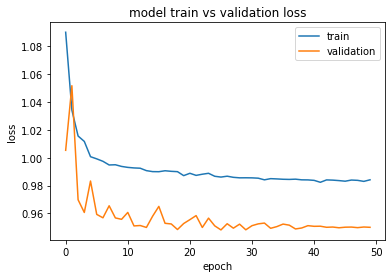

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [95]:
predictions = model.predict(X1_test, batch_size = 64, verbose = 1)

18/18 [==============================] - 1s 49ms/step


In [99]:
len(predictions)

1144

In [100]:
predictions

array([[0.5400729 , 0.16249028, 0.29743674],
       [0.54062474, 0.16139238, 0.29798293],
       [0.5401304 , 0.1623917 , 0.29747793],
       ...,
       [0.59090406, 0.11814252, 0.29095343],
       [0.59090406, 0.11814252, 0.29095343],
       [0.59090406, 0.11814252, 0.29095343]], dtype=float32)

In [1]:
UAR(y1_test, predictions)

NameError: ignored